In [1]:
# Import necessary libraries
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
import json
import csv
import numpy as np

In [2]:
# Prepare dataset
df = pd.read_excel("./csv/landmark_digitalization.xlsx")
df['image'] = df['ant'].apply(lambda x: str(x) + '_p_1.jpg')

# Split the dataframe into train, validation, and test sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.2, random_state=42)

train_df.to_csv("./resnet_dataset/train.csv", index=False)
val_df.to_csv("./resnet_dataset/val.csv", index=False)
test_df.to_csv("./resnet_dataset/test.csv", index=False)


In [8]:
class LandmarkDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx]['image'])
        image = Image.open(img_name).convert('RGB')
        width, height = image.size
        landmarks = np.array(self.df.iloc[idx][['x1_lmk','y1_lmk','x2_lmk','y2_lmk']].values, dtype=np.float32) 
        
        landmarks[0] *= 1/width # x1_lmk
        landmarks[2] *= 1/width  # x2_lmk

        landmarks[1] = (height - landmarks[1])/height # y1_lmk
        landmarks[3] = (height - landmarks[3])/height  # y2_lmk

        if self.transform:
            image = self.transform(image)
        else:
            # Define transformation for image
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Imagenet normalization
            ])
            image = transform(image)

        return image, torch.tensor(landmarks)


In [9]:
# Create Datasets and DataLoaders
train_dataset = LandmarkDataset(csv_file='./resnet_dataset/train.csv', img_dir='./original')
val_dataset = LandmarkDataset(csv_file='./resnet_dataset/val.csv', img_dir='./original')
test_dataset = LandmarkDataset(csv_file='./resnet_dataset/test.csv', img_dir='./original')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [10]:
class LandmarkResNet18(torch.nn.Module):
    def __init__(self):
        super(LandmarkResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, 4)  # Output 4 coordinates (x1, y1, x2, y2)

    def forward(self, x):
        return self.resnet(x)

# Instantiate the model
model = LandmarkResNet18()

# Loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, landmarks in train_loader:
        images, landmarks = images.to(device), landmarks.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, landmarks)
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    with torch.no_grad():
        val_loss = 0.0
        for images, landmarks in val_loader:
            images, landmarks = images.to(device), landmarks.to(device).float()
            outputs = model(images)
            val_loss += criterion(outputs, landmarks).item()
            
    print(f"Epoch [{epoch+1}/{num_epochs}], Epoch Loss: {avg_loss:.4f}, Val Loss: {val_loss / len(val_loader):.4f}")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971132/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/100], Epoch Loss: 0.5913, Val Loss: 0.5805
Epoch [2/100], Epoch Loss: 0.5016, Val Loss: 0.5352
Epoch [3/100], Epoch Loss: 0.4345, Val Loss: 0.4958
Epoch [4/100], Epoch Loss: 0.3777, Val Loss: 0.4598
Epoch [5/100], Epoch Loss: 0.3321, Val Loss: 0.4271
Epoch [6/100], Epoch Loss: 0.2957, Val Loss: 0.3974
Epoch [7/100], Epoch Loss: 0.2599, Val Loss: 0.3700
Epoch [8/100], Epoch Loss: 0.2290, Val Loss: 0.3451
Epoch [9/100], Epoch Loss: 0.2007, Val Loss: 0.3227
Epoch [10/100], Epoch Loss: 0.1759, Val Loss: 0.3024
Epoch [11/100], Epoch Loss: 0.1535, Val Loss: 0.2836
Epoch [12/100], Epoch Loss: 0.1344, Val Loss: 0.2667
Epoch [13/100], Epoch Loss: 0.1171, Val Loss: 0.2508
Epoch [14/100], Epoch Loss: 0.1044, Val Loss: 0.2360
Epoch [15/100], Epoch Loss: 0.0887, Val Loss: 0.2225
Epoch [16/100], Epoch Loss: 0.0763, Val Loss: 0.2101
Epoch [17/100], Epoch Loss: 0.0679, Val Loss: 0.1990
Epoch [18/100], Epoch Loss: 0.0573, Val Loss: 0.1890
Epoch [19/100], Epoch Loss: 0.0499, Val Loss: 0.1800
Ep

In [11]:
# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    total_error = 0
    num_samples = 0

    with torch.no_grad():
        for images, true_labels in test_loader:
            images, true_labels = images.to(device), true_labels.to(device)
            predictions = model(images)
            error = torch.mean(torch.sqrt(torch.sum((predictions - true_labels) ** 2, dim=1)))
            total_error += error.item() * len(images)
            num_samples += len(images)

    return total_error / num_samples

# Compute test error
test_error = evaluate_model(model, test_loader)
print(f"Mean Euclidean Distance on Test Set: {test_error:.4f}")

Mean Euclidean Distance on Test Set: 0.4853


tensor(0.8798, grad_fn=<SqrtBackward0>)


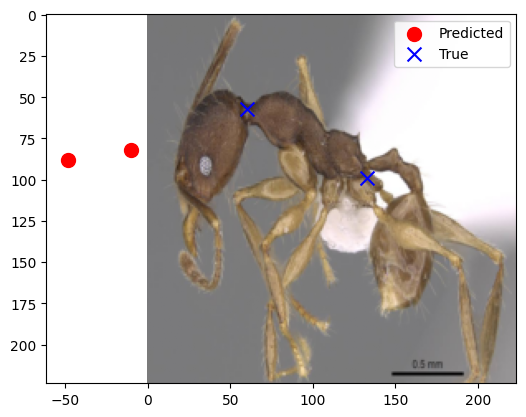

In [12]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T

def visualize_predictions(image, predictions, true_labels):
    # Denormalize the image
    image = torch.clamp(image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1), 0, 1) 
    image = image.permute(1, 2, 0)  # Change to HWC format for plt.imshow

    # Denormalize coordinates
    height, width = image.shape[:2]
    x1, y1, x2, y2 = predictions * torch.tensor([width, height, width, height])
    true_x1, true_y1, true_x2, true_y2 = true_labels * torch.tensor([width, height, width, height])

    # Convert coordinates to integers for plotting
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
    true_x1, true_y1, true_x2, true_y2 = map(int, [true_x1, true_y1, true_x2, true_y2])

    # Plot the image and the bounding boxes
    plt.imshow(image)
    plt.scatter([x1, x2], [y1, y2], c="red", s=100, label="Predicted")
    plt.scatter([true_x1, true_x2], [true_y1, true_y2], c="blue", s=100, label="True", marker='x')
    plt.legend()
    plt.show()


for img_batch, label_batch in test_loader:
    img, true_labels = img_batch[0], label_batch[0]
    prediction = model(img.unsqueeze(0).to(device)).cpu().squeeze()
    print(torch.sqrt(torch.sum((prediction - true_labels) ** 2)))
    visualize_predictions(img, prediction, true_labels)
    break

In [13]:
prediction

tensor([-0.0466,  0.3667, -0.2168,  0.3940], grad_fn=<SqueezeBackward0>)